## Librerías

In [30]:
# Tratamientos de datos y gráficos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

#Statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

#Metricas
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

#Mecanismos de Ajuste
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax

#Skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax

#Advertencias
import warnings
warnings.filterwarnings('ignore')

plt.style.use("seaborn-v0_8-darkgrid")

## Datos
Resumen del consumo mensual de combustible en españa

In [2]:
datos = pd.read_csv('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/master/data/consumos-combustibles-mensual.csv', sep = ',')
datos

,Fecha,GLPs,Gasolinas,Querosenos,Gasoleos,Fueloleos
0,1969-01-01,133615.09620,166875.2129,123257.8090,4.011853e+05,912583.4202
1,1969-02-01,126748.47410,155466.8105,114682.5767,3.853600e+05,851877.8115
2,1969-03-01,107795.80910,184983.6699,109970.0796,4.189556e+05,873884.2933
3,1969-04-01,96683.15967,202319.8164,108797.9255,4.389755e+05,755490.1170
4,1969-05-01,79506.23804,206259.1523,103554.0784,4.674519e+05,729963.6009
...,...,...,...,...,...,...
639,2022-04-01,179591.64000,471601.9400,494966.3200,2.638030e+06,636930.4200
640,2022-05-01,134166.56000,478873.4100,530034.0100,2.673797e+06,708289.2600
641,2022-06-01,142480.09000,501447.1400,540594.9700,2.648087e+06,667221.4500
642,2022-07-01,135984.49000,534584.6800,607854.6800,2.613591e+06,691371.6000


In [3]:
datos = datos[['Fecha', 'Gasolinas']]
datos = datos.rename(columns={'Fecha': 'date', 'Gasolinas':'litters'})

datos['date'] = pd.to_datetime(datos['date'], format='%Y-%m-%d')
datos.set_index('date', inplace=True)
datos.head()

,litters
date,
1969-01-01,166875.2129
1969-02-01,155466.8105
1969-03-01,184983.6699
1969-04-01,202319.8164
1969-05-01,206259.1523


In [4]:
datos= datos.loc[:'1990-01-01']
datos

,litters
date,
1969-01-01,166875.2129
1969-02-01,155466.8105
1969-03-01,184983.6699
1969-04-01,202319.8164
1969-05-01,206259.1523
...,...
1989-09-01,687649.2852
1989-10-01,669889.1602
1989-11-01,601413.8867


In [5]:
datos = datos.asfreq('MS')
datos = datos['litters']
type(datos) #Verificar que se vuelva serie de tiempo

pandas.core.series.Series

Crear un conjunto de ajuste y un conjunto de validación

In [6]:
fin_ajuste = '1980-01-01'
print(f'Fechas ajuste: {datos.index.min()} --- {datos.loc[:fin_ajuste].index.max()} n={len(datos.loc[:fin_ajuste])}')

print(f'Fechas validación: {datos.loc[fin_ajuste:].index.min()} --- {datos.loc[fin_ajuste:].index.max()} n={len(datos.loc[fin_ajuste:])}')

Fechas ajuste: 1969-01-01 00:00:00 --- 1980-01-01 00:00:00 n=133
Fechas validación: 1980-01-01 00:00:00 --- 1990-01-01 00:00:00 n=121


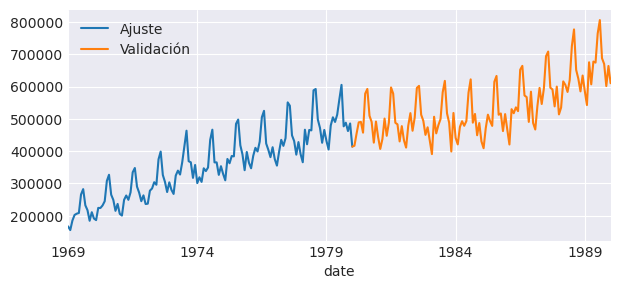

In [7]:
datos_ajuste = datos.loc[:fin_ajuste]
datos_validacion = datos.loc[fin_ajuste:]

plt.figure(figsize=(7,3))

datos_ajuste.plot(label = 'Ajuste')
datos_validacion.plot(label = 'Validación')
plt.legend()

plt.show()


## Análisis SARIMA

1. Estacionariedad
2. Autocorrelación
3. Descomposición


#### Estacionariedad

- Test Dickey - Fuller
- Test KPSS

In [8]:
print('Test de estacionariedad para la serie original')
print('----------------------------------------------')

adfuller_result = adfuller(datos)
kpss_result = kpss(datos)

print(f'Estadistico ADF: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

print(f'Estadistico KPSS: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test de estacionariedad para la serie original
----------------------------------------------
Estadistico ADF: -0.4461298099822785, p-value: 0.9021071923942668
Estadistico KPSS: 2.2096370946978383, p-value: 0.01


In [9]:
datos_diff_1 = datos.diff().dropna()

print('Test de estacionariedad para la serie diferencial en orden 1')
print('----------------------------------------------')

adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(datos_diff_1)

print(f'Estadistico ADF: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

print(f'Estadistico KPSS: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test de estacionariedad para la serie diferencial en orden 1
----------------------------------------------
Estadistico ADF: -2.459285585433211, p-value: 0.1256973823175208
Estadistico KPSS: 0.3132711623572802, p-value: 0.1


In [10]:
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test de estacionariedad para la serie diferencial en orden 1')
print('----------------------------------------------')

adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(datos_diff_2)

print(f'Estadistico ADF: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

print(f'Estadistico KPSS: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test de estacionariedad para la serie diferencial en orden 1
----------------------------------------------
Estadistico ADF: -11.117483376374553, p-value: 3.533286742434965e-20
Estadistico KPSS: 0.08065668267482112, p-value: 0.1


Se necesitaron Dos transformaciones para que la serie fuera estacionaria

Por tanto:

#### SARIMAX(p, 2, q) (P,D,Q)f

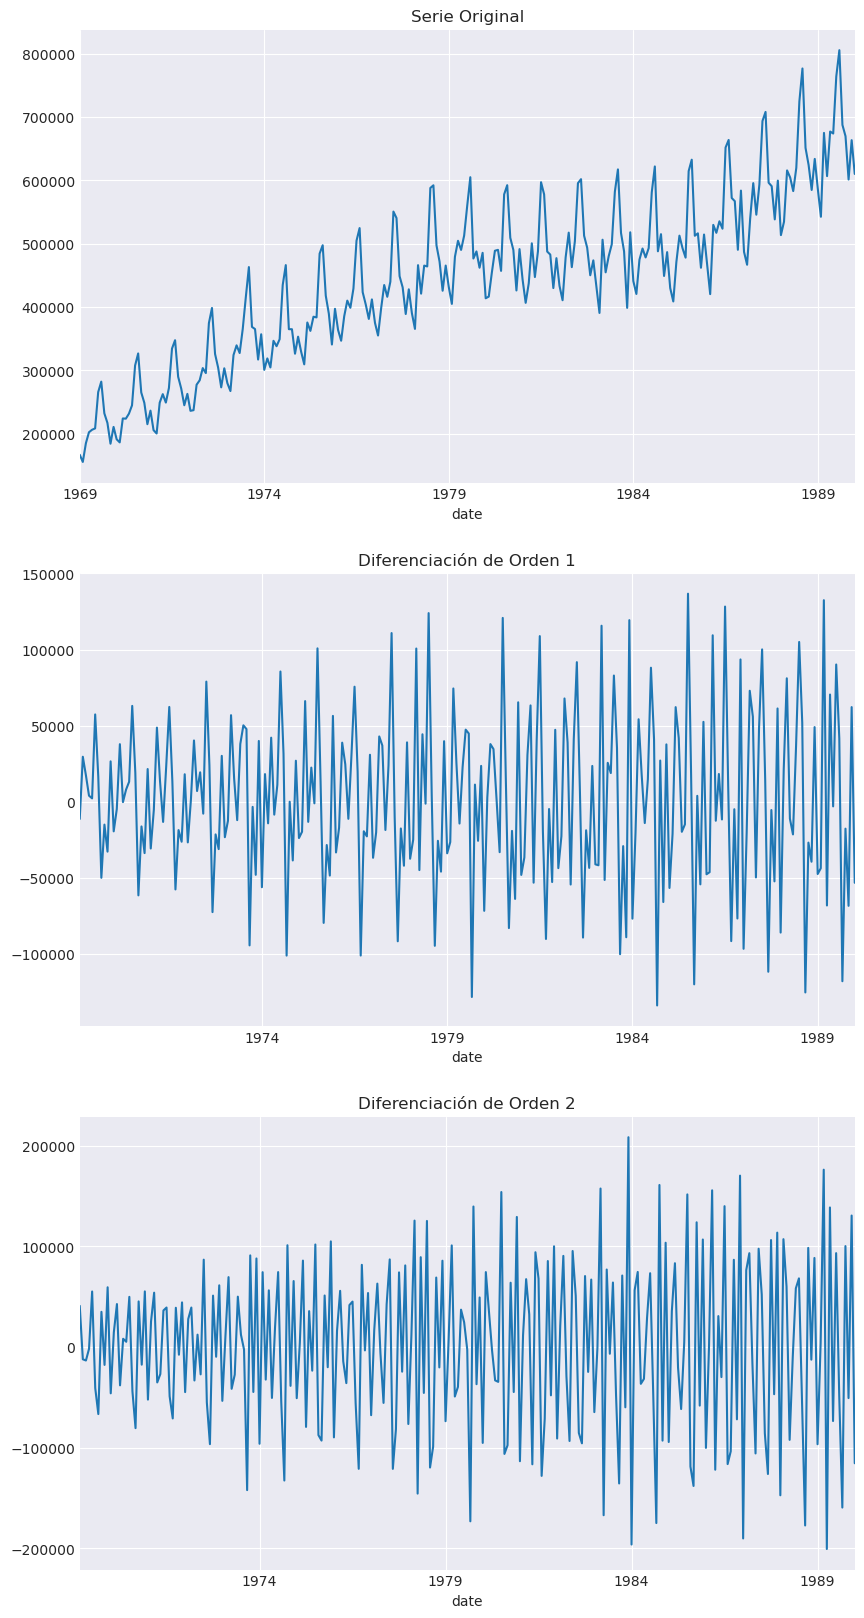

In [11]:
fig, ax = plt.subplots(3,1,figsize=(10,20))

datos.plot(ax = ax[0], title='Serie Original')
datos_diff_1.plot(ax = ax[1], title="Diferenciación de Orden 1")
datos_diff_2.plot(ax = ax[2], title="Diferenciación de Orden 2")

plt.show()

### Validar Autocorrelación

- ACF
- PACF

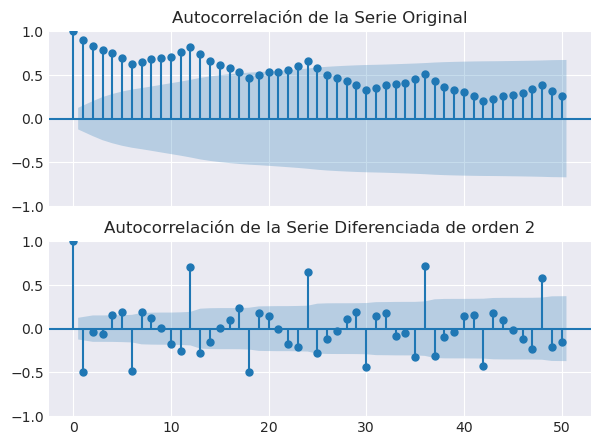

In [12]:
#Gráfico Autocorrelación
fig, ax = plt.subplots(2, 1, figsize=(7,5), sharex = True)

plot_acf(datos, ax = ax[0], lags=50)
ax[0].set_title("Autocorrelación de la Serie Original")

plot_acf(datos_diff_2, ax = ax[1], lags=50)
ax[1].set_title("Autocorrelación de la Serie Diferenciada de orden 2")

plt.show()

Se ignora la primera barra que siempre será igual a 1. Luego se cuentan la cantidad de barras por fuera del intervalo de confianza antes de que la primera quede dentro.

#### SARIMAX(p, 2, 1) (P,D,Q)f

## Autocorrelación Parcial

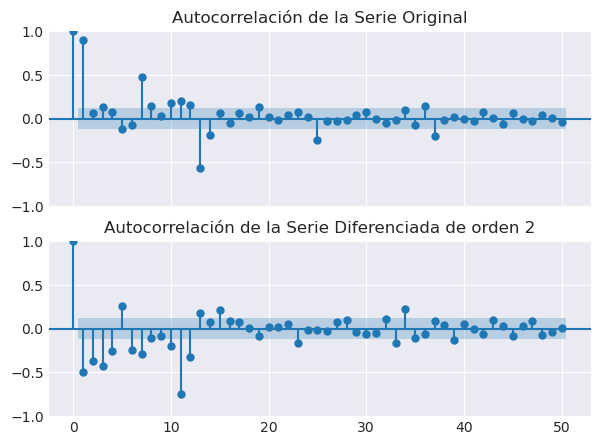

In [13]:
#Gráfico Autocorrelación
fig, ax = plt.subplots(2, 1, figsize=(7,5), sharex = True)

plot_pacf(datos, ax = ax[0], lags=50)
ax[0].set_title("Autocorrelación de la Serie Original")

plot_pacf(datos_diff_2, ax = ax[1], lags=50)
ax[1].set_title("Autocorrelación de la Serie Diferenciada de orden 2")

plt.show()

Con una interpretación igual a la de ACF, se cuentan 8 barras antes de la primera dentro de la sombra.

Ergo:

#### SARIMAX(8,2,1)(P,D,Q)f

## Descomposición

- Tendencia
- Estacionalidades
- Aleatoriedad

Text(0.5, 1.0, 'Aleatoriedad Diferencial Orden 2')

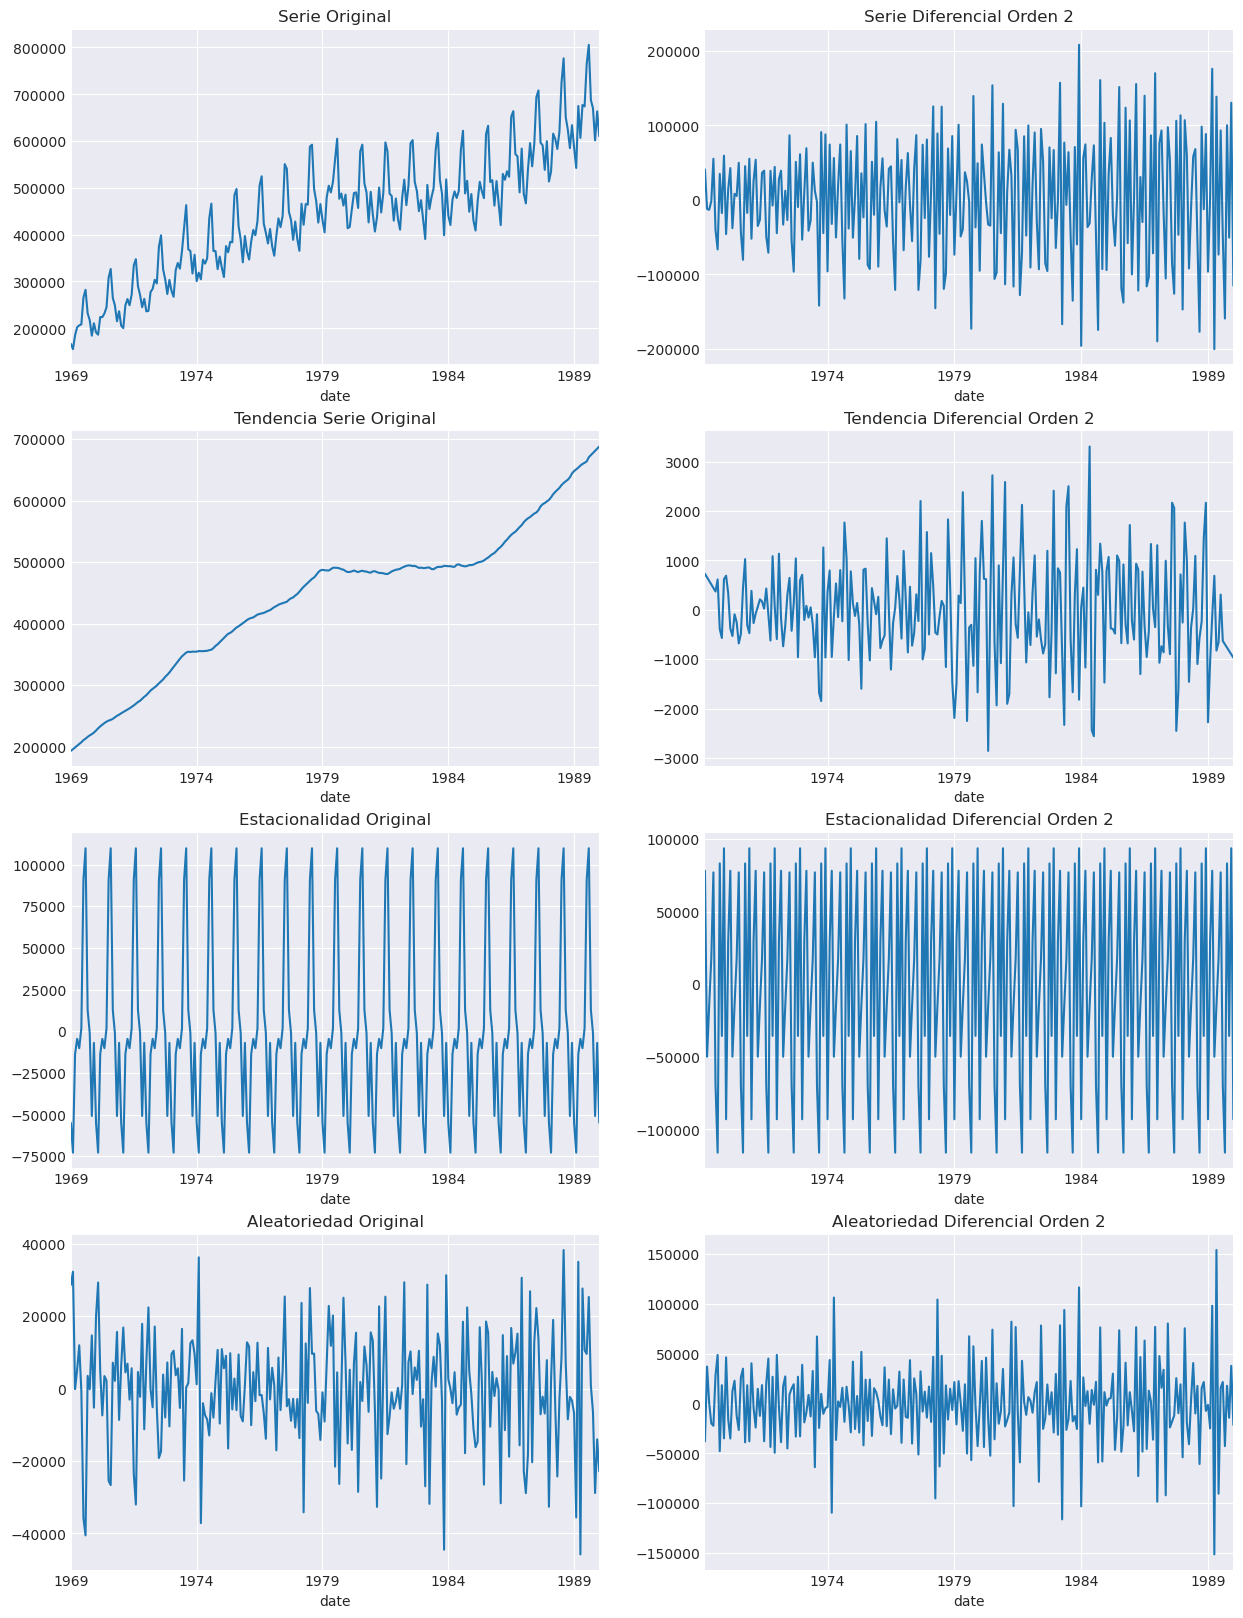

In [14]:
res_decompose = seasonal_decompose(datos, model= 'additive', extrapolate_trend= "freq")
res_decompose_diff_2 = seasonal_decompose(datos_diff_2, model= 'additive', extrapolate_trend= "freq")

fig, ax = plt.subplots(4,2,figsize=(15,20))
res_decompose.observed.plot(ax = ax[0,0])
ax[0,0].set_title("Serie Original")

res_decompose.trend.plot(ax = ax[1,0])
ax[1,0].set_title("Tendencia Serie Original")

res_decompose.seasonal.plot(ax = ax[2,0])
ax[2,0].set_title("Estacionalidad Original")

res_decompose.resid.plot(ax = ax[3,0])
ax[3,0].set_title("Aleatoriedad Original")

### SERIE DIFERENCIAL

res_decompose_diff_2.observed.plot(ax = ax[0,1])
ax[0,1].set_title("Serie Diferencial Orden 2")

res_decompose_diff_2.trend.plot(ax = ax[1,1])
ax[1,1].set_title("Tendencia Diferencial Orden 2")

res_decompose_diff_2.seasonal.plot(ax = ax[2,1])
ax[2,1].set_title("Estacionalidad Diferencial Orden 2")

res_decompose_diff_2.resid.plot(ax = ax[3,1])
ax[3,1].set_title("Aleatoriedad Diferencial Orden 2")

Encontrados los patrones estacionales en la serie. Tanto original, como la estacionaria (diferencial de orden 2) descompuesta.

La repetición además se identifica que es anual. Como tenemos un dato por mes, la frecuencia es 12

#### SARIMAX(8,2,1)(P,D,Q)12

Ahora hay que encontrar **P, D y Q** para el modelo SARIMAX

In [19]:
datos_diff_2_12 = datos_diff_2.diff(12).dropna()#Para obtener valores del componente estacional

adfuller_result = adfuller(datos_diff_2_12)
print(f"ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}")

kpss_result = kpss(datos_diff_2_12)
print(f"KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}")

ADF Statistic: -6.330635011378028, p-value: 2.9122529506067277e-08
KPSS Statistic: 0.0568493896694262, p-value: 0.1


<Figure size 700x300 with 0 Axes>

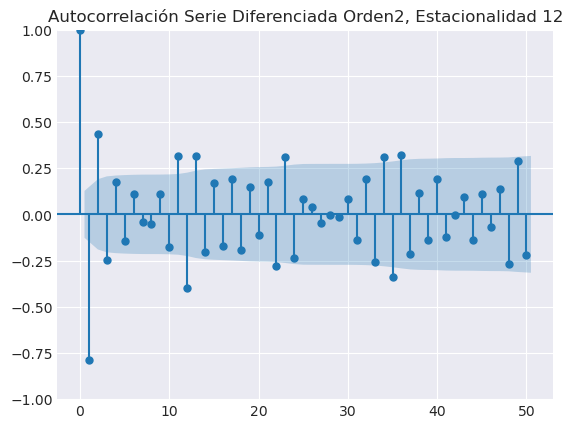

In [20]:
plt.figure(figsize=(7,3))

plot_acf(datos_diff_2_12, lags= 50)

plt.title("Autocorrelación Serie Diferenciada Orden2, Estacionalidad 12")
plt.show()

De la misma forma que encontramos q miramos en la gráfica. **Q = 3**

Ahora se realiza lo mismo con PACF para identificar **P**

<Figure size 700x300 with 0 Axes>

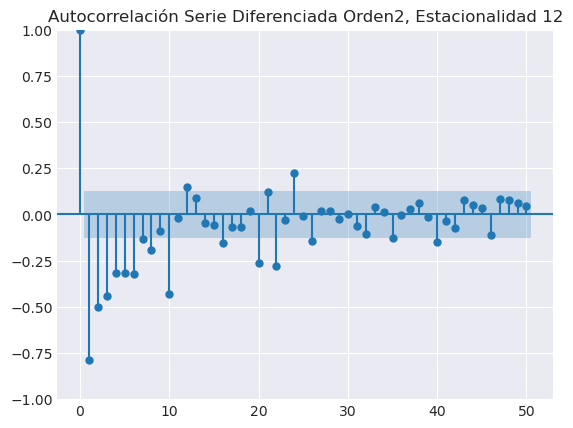

In [22]:
plt.figure(figsize=(7,3))

plot_pacf(datos_diff_2_12, lags= 50, method="ywm")

plt.title("Autocorrelación Serie Diferenciada Orden2, Estacionalidad 12")
plt.show()

**P = 9**

# Modelo SARIMA Final:

#### SARIMAX(8,2,1)(8,2,3)12

In [23]:
modelo = SARIMAX(endog = datos_ajuste, order = (8,2,1), seasonal_order=(8,2,3, 12))

modelo_res = modelo.fit()
modelo_res.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20756D+01    |proj g|=  5.02095D+00


 This problem is unconstrained.



At iterate    5    f=  9.26419D+00    |proj g|=  3.22187D-02

At iterate   10    f=  9.24913D+00    |proj g|=  8.24896D-03

At iterate   15    f=  9.24774D+00    |proj g|=  3.96603D-03

At iterate   20    f=  9.24723D+00    |proj g|=  2.43095D-03

At iterate   25    f=  9.24715D+00    |proj g|=  1.04740D-03

At iterate   30    f=  9.24705D+00    |proj g|=  2.18900D-03

At iterate   35    f=  9.24701D+00    |proj g|=  4.13209D-04

At iterate   40    f=  9.24701D+00    |proj g|=  2.72770D-04

At iterate   45    f=  9.24701D+00    |proj g|=  1.10092D-04

At iterate   50    f=  9.24701D+00    |proj g|=  4.43904D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                    litters   No. Observations:                  133
Model:             SARIMAX(8, 2, 1)x(8, 2, [1, 2, 3], 12)   Log Likelihood               -1229.852
Date:                                    Sun, 01 Oct 2023   AIC                           2501.704
Time:                                            19:50:20   BIC                           2557.834
Sample:                                        01-01-1969   HQIC                          2524.459
                                             - 01-01-1980                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9180      0.475     -1.934      0.053      -1.848       0.012
ar.L2         -0.4435      0.736     -0.603      0.547      -1.886       0.999
ar.L3         -0.3621      0.734     -0.494      0.622      -1.800       1.076
ar.L4         -0.3657      0.782     -0.468      0.640      -1.898       1.166
ar.L5         -0.2898      0.833     -0.348      0.728      -1.923       1.343
ar.L6         -0.1201      0.830     -0.145      0.885      -1.748       1.508
ar.L7         -0.0486      0.717     -0.068      0.946      -1.454       1.357
ar.L8          0.0565      0.443      0.127      0.899      -0.813       0.926
ma.L1         -0.8086      0.373     -2.165      0.030      -1.541      -0.077
ar.S.L12      -0.5076    342.418     -0.001      0.999    -671.635     670.620
ar.S.L24      -0.1943    120.790     -0.002      0.999    -236.937     236.549
ar.S.L36      -0.3081    207.153     -0.001      0.999    -406.320     405.704
ar.S.L48      -0.2542    141.965     -0.002      0.999    -278.500     277.992
ar.S.L60      -0.2874    110.382     -0.003      0.998    -216.633     216.058
ar.S.L72      -0.1176     94.711     -0.001      0.999    -185.747     185.512
ar.S.L84      -0.0279     30.529     -0.001      0.999     -59.864      59.808
ar.S.L96      -0.0076     19.524     -0.000      1.000     -38.274      38.259
ma.S.L12      -0.5050    342.600     -0.001      0.999    -671.989     670.978
ma.S.L24      -0.1651    226.538     -0.001      0.999    -444.171     443.841
ma.S.L36       0.3341    138.575      0.002      0.998    -271.268     271.936
sigma2      9.826e+08      0.001   9.91e+11      0.000    9.83e+08    9.83e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.57
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               1.50   Skew:                            -0.32
Prob(H) (two-sided):                  0.23   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.67e+27. Standard errors may be unstable.
"""

In [24]:
predicciones_statsmodels = modelo_res.get_forecast(steps = len(datos_validacion)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
predicciones_statsmodels

1980-02-01    4.024217e+05
1980-03-01    4.533185e+05
1980-04-01    4.957140e+05
1980-05-01    4.737237e+05
1980-06-01    5.023663e+05
                  ...     
1989-10-01   -2.132596e+06
1989-11-01   -2.195962e+06
1989-12-01   -2.236786e+06
1990-01-01   -2.424465e+06
1990-02-01   -2.480406e+06
Freq: MS, Name: predicciones_statsmodels, Length: 121, dtype: float64

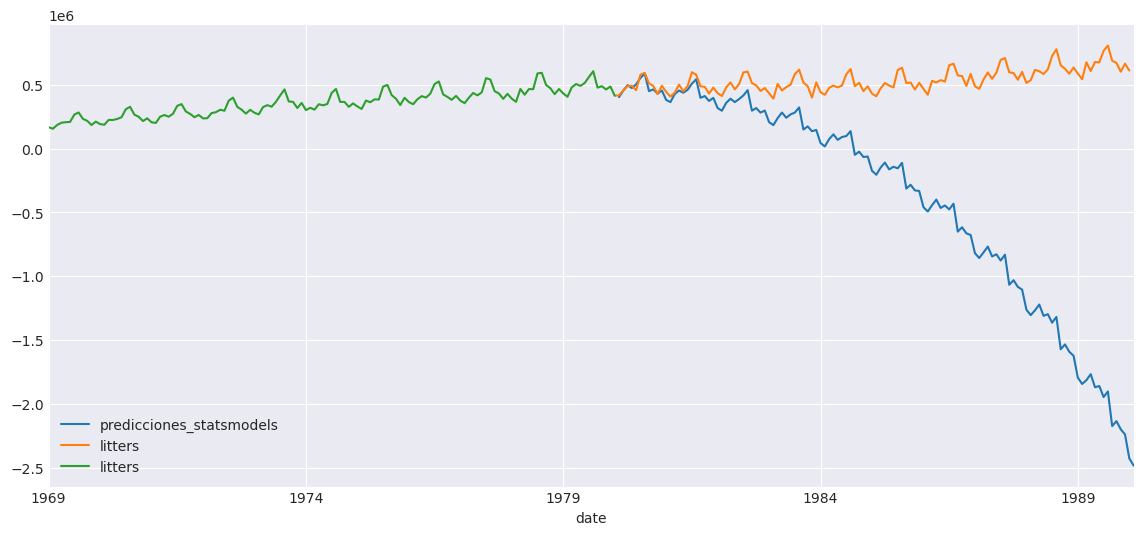

In [28]:
plt.figure(figsize=(14,6))

predicciones_statsmodels.plot()
datos_validacion.plot()
datos_ajuste.plot()

plt.legend()

plt.show()

## Intentar SARIMAX de forecaster

In [31]:
modelo = Sarimax(order = (8,2,1), seasonal_order=(8,2,3, 12))
modelo.fit(y = datos_ajuste)
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                    litters   No. Observations:                  133
Model:             SARIMAX(8, 2, 1)x(8, 2, [1, 2, 3], 12)   Log Likelihood               -1229.852
Date:                                    Sun, 01 Oct 2023   AIC                           2501.704
Time:                                            20:12:59   BIC                           2557.834
Sample:                                        01-01-1969   HQIC                          2524.459
                                             - 01-01-1980                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9180      0.475     -1.934      0.053      -1.848       0.012
ar.L2         -0.4435      0.736     -0.603      0.547      -1.886       0.999
ar.L3         -0.3621      0.734     -0.494      0.622      -1.800       1.076
ar.L4         -0.3657      0.782     -0.468      0.640      -1.898       1.166
ar.L5         -0.2898      0.833     -0.348      0.728      -1.923       1.343
ar.L6         -0.1201      0.830     -0.145      0.885      -1.748       1.508
ar.L7         -0.0486      0.717     -0.068      0.946      -1.454       1.357
ar.L8          0.0565      0.443      0.127      0.899      -0.813       0.926
ma.L1         -0.8086      0.373     -2.165      0.030      -1.541      -0.077
ar.S.L12      -0.5076    342.418     -0.001      0.999    -671.635     670.620
ar.S.L24      -0.1943    120.790     -0.002      0.999    -236.937     236.549
ar.S.L36      -0.3081    207.153     -0.001      0.999    -406.320     405.704
ar.S.L48      -0.2542    141.965     -0.002      0.999    -278.500     277.992
ar.S.L60      -0.2874    110.382     -0.003      0.998    -216.633     216.058
ar.S.L72      -0.1176     94.711     -0.001      0.999    -185.747     185.512
ar.S.L84      -0.0279     30.529     -0.001      0.999     -59.864      59.808
ar.S.L96      -0.0076     19.524     -0.000      1.000     -38.274      38.259
ma.S.L12      -0.5050    342.600     -0.001      0.999    -671.989     670.978
ma.S.L24      -0.1651    226.538     -0.001      0.999    -444.171     443.841
ma.S.L36       0.3341    138.575      0.002      0.998    -271.268     271.936
sigma2      9.826e+08      0.001   9.91e+11      0.000    9.83e+08    9.83e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.57
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               1.50   Skew:                            -0.32
Prob(H) (two-sided):                  0.23   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.67e+27. Standard errors may be unstable.
"""

In [33]:
predicciones_skforecast = modelo.predict(steps = len(datos_validacion))
predicciones_skforecast.head()

,pred
1980-02-01,402421.671373
1980-03-01,453318.500422
1980-04-01,495714.044563
1980-05-01,473723.695081
1980-06-01,502366.296234


<Figure size 1400x600 with 0 Axes>

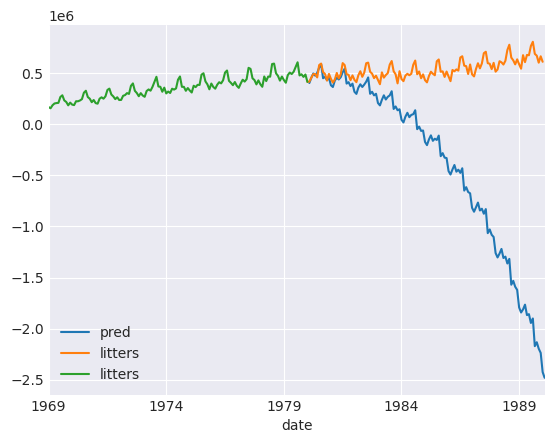

In [34]:
plt.figure(figsize=(14,6))

predicciones_skforecast.plot()
datos_validacion.plot()
datos_ajuste.plot()

plt.legend()

plt.show()

In [ ]:
modelo = ARIMA(order = (8,2,1), seasonal_order=(8,2,3, 12))
modelo.fit(y = datos_ajuste)
modelo.summary()

In [35]:
predicciones_pmarima = modelo.predict(steps = len(datos_validacion))
predicciones_pmarima.head()

,pred
1980-02-01,402421.671373
1980-03-01,453318.500422
1980-04-01,495714.044563
1980-05-01,473723.695081
1980-06-01,502366.296234


<Figure size 1400x600 with 0 Axes>

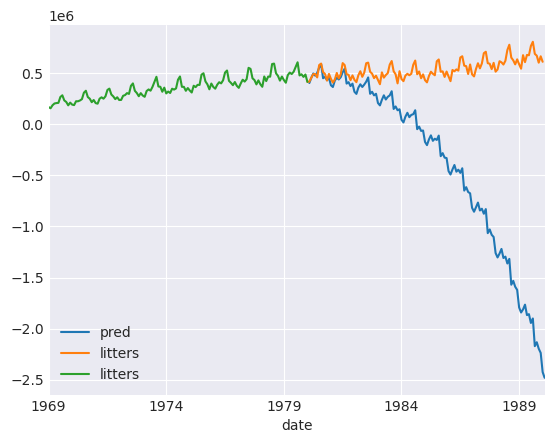

In [36]:
plt.figure(figsize=(14,6))

predicciones_pmarima.plot()
datos_validacion.plot()
datos_ajuste.plot()

plt.legend()

plt.show()

## Backtesting para modelo ARIMA

Similar a la validación cruzada en modelos de machine learning

In [41]:
regressor = Sarimax(order = (1,1,1), seasonal_order=(1,1,1,12))
forecaster = ForecasterSarimax(regressor=regressor)

metrica, predicciones = backtesting_sarimax(forecaster= forecaster,
                                            y = datos,
                                            initial_train_size = len(datos_ajuste),
                                            steps = 12,
                                            metric = 'mean_absolute_error',
                                            refit = True,
                                            n_jobs = 'auto',
                                            suppress_warnings_fit = True,
                                            verbose = True,
                                            show_progress = True)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 133
Number of observations used for backtesting: 120
    Number of folds: 10
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1969-01-01 00:00:00 -- 1980-01-01 00:00:00  (n=133)
    Validation: 1980-02-01 00:00:00 -- 1981-01-01 00:00:00  (n=12)
Fold: 1
    Training:   1970-01-01 00:00:00 -- 1981-01-01 00:00:00  (n=133)
    Validation: 1981-02-01 00:00:00 -- 1982-01-01 00:00:00  (n=12)
Fold: 2
    Training:   1971-01-01 00:00:00 -- 1982-01-01 00:00:00  (n=133)
    Validation: 1982-02-01 00:00:00 -- 1983-01-01 00:00:00  (n=12)
Fold: 3
    Training:   1972-01-01 00:00:00 -- 1983-01-01 00:00:00  (n=133)
    Validation: 1983-02-01 00:00:00 -- 1984-01-01 00:00:00  (n=12)
Fold: 4
    Training:   1973-01-01 00:00:00 -- 1984-01-01 00:00:00  (n=133)
    Validation: 1984-02-01 00:00:00 --

100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


In [42]:
print(f"Metrica (MAE): {metrica}")
predicciones

Metrica (MAE): 20528.19077360724


,pred
1980-02-01,407504.056940
1980-03-01,473997.245798
1980-04-01,489983.091487
1980-05-01,485517.462856
1980-06-01,504445.207327
...,...
1989-09-01,700291.918834
1989-10-01,681322.871643
1989-11-01,635027.761020
1989-12-01,689024.418875


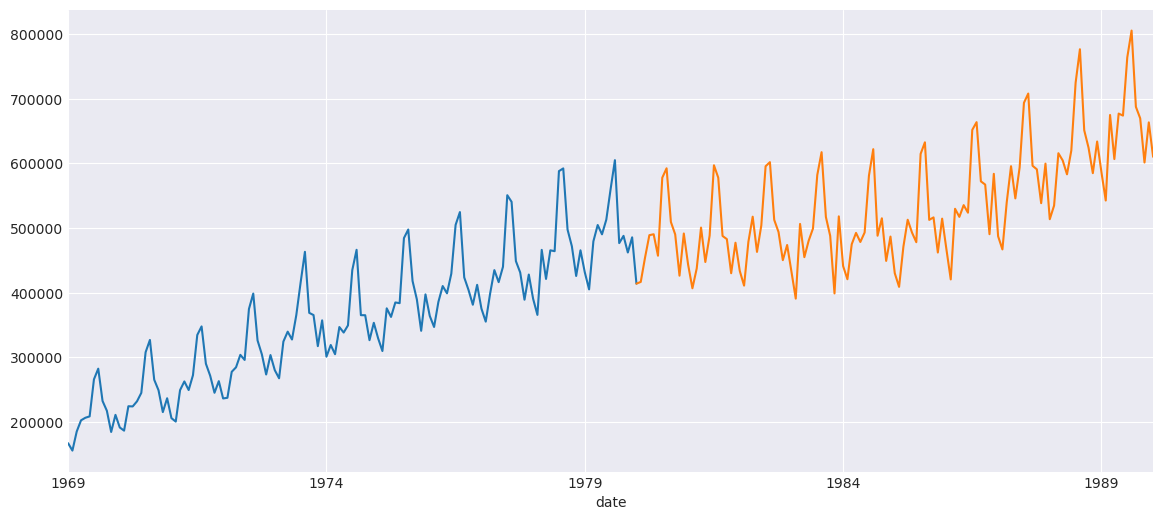

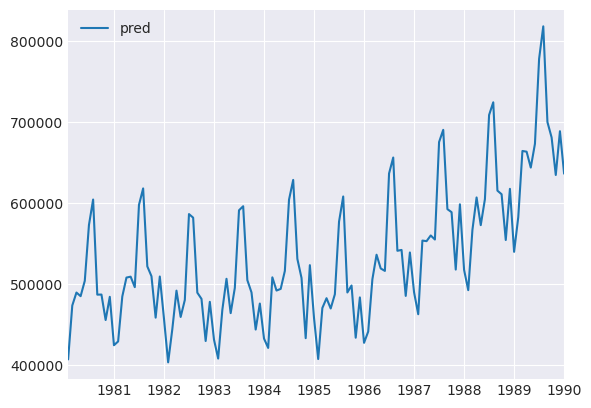

In [45]:
predicciones_backtesting = modelo.predict(steps = len(datos_validacion))

plt.figure(figsize=(14,6))

datos_ajuste.plot()
datos_validacion.plot()
predicciones.plot()

plt.legend()

plt.show()